In [127]:
import warnings
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
_distn_names = ["johnsonsu", "johnsonsb", "uniform", "cauchy", "chi", "burr", "expon", "dweibull", "crystalball", "gamma", "rice", "pareto"]

data1 = pd.read_csv('Telecom_customer churn.csv')  
dataframe=data1.copy()

In [129]:
# print(training_set.loc[[1]])
dataframe=dataframe.sample(frac=1).reset_index(drop=True) #Shuffles rows randomly
# print(training_set.loc[[1]])
training_set=dataframe.iloc[0:80000 , : ] #Filters out the first 80000 rows
# training_set.info()

test_set=dataframe.iloc[80001: , : ]
#test_set.info()

In [130]:
#to identify categorical data in the dataframe
data_cat = training_set.select_dtypes(exclude=["number","bool_","float_"]) 
# print(data_cat.head()) 

#to set all null data to a 'DidNotSpecify' field
for column in data_cat :
    data_cat[column] = data_cat[column].fillna("DNS") 

data_cat    

C:\Users\Owner\AppData\Local\Temp/ipykernel_15376/4019379856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat[column] = data_cat[column].fillna("DNS")


,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,ownrent,dwlltype,...,infobase,HHstatin,dwllsize,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,AA,N,S,NORTHWEST/ROCKY MOUNTAIN AREA,T,N,WCMB,O,S,...,M,I,A,N,U,U,U,U,Y,Y
1,U,A,N,C,CALIFORNIA NORTH AREA,Y,N,WC,O,S,...,M,DNS,A,O,U,U,U,Y,U,Y
2,U,BA,N,DNS,CHICAGO AREA,T,N,WCMB,DNS,S,...,M,I,A,M,U,U,Y,U,U,N
3,U,B,N,S,CENTRAL/SOUTH TEXAS AREA,Y,N,DNS,DNS,DNS,...,M,A,DNS,H,U,U,U,U,U,Y
4,N,A,N,DNS,NEW YORK CITY AREA,Y,N,WCMB,O,DNS,...,M,G,DNS,G,U,U,U,U,U,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,N,D4,Y,C,PHILADELPHIA AREA,Y,N,WCMB,O,S,...,M,DNS,A,S,U,U,U,U,U,Y
79996,U,E4,Y,C,SOUTHWEST AREA,Y,N,WCMB,DNS,DNS,...,DNS,DNS,DNS,U,U,U,U,U,U,N
79997,U,AA,N,S,NEW ENGLAND AREA,Y,N,WCMB,O,S,...,M,C,A,N,U,U,U,U,U,Y
79998,U,AA,N,U,NEW YORK CITY AREA,Y,N,WCMB,O,M,...,M,DNS,O,J,U,U,U,U,U,Y


In [135]:
#to get the pmf of the categorical data
all_pmfs = []
for column in data_cat :
    pmf = data_cat[column].value_counts().sort_index() / len(data_cat) 
    all_pmfs.append(pmf)
    #plt.figure()
    #pmf.plot(kind = 'bar') 
    #plt.title(" " + column)
    #plt.show()


#the data churn is more logical to have a pmf for it instead of a pdf 
pmf = training_set["churn"].value_counts().sort_index() / len(training_set)
all_pmfs.append(pmf) 
#plt.figure()
#pmf.plot(kind = 'bar') 
#plt.title("Churn") 
pr_pmf = [] 
i = 0
while i < 80000 :

 c0 = 0
 p0 = 1 
 for column in data_cat :
   n = data_cat.at[i, column]  
   v = all_pmfs[c0].loc[n]
   p0 *= v 
   c0 += 1
 i+=1 
 pr_pmf.append(p0)   

p0

2.77190848236385e-11

In [136]:
#to identify numerical data in the dataframe
data_num = training_set.select_dtypes(exclude=["object_","bool_"]) 
     
data_num.drop(['da_Mean', 'vceovr_Mean', 'datovr_Mean', 'drop_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_dat_Mean', 'comp_dat_Mean', 'threeway_Mean', 'owylis_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkd_Mean', 'callfwdv_Mean', 'actvsubs', 'phones', 'models', 'truck', 'rv', 'adults', 'forgntvl', 'Customer_ID'], axis=1, inplace=True)

# infinity data 'if found'
# print(data_num.index[np.isinf(data_num).any(1)])

# to fill empty spaces in each column with suitable replacement
for column in data_num :
   data_num[column] = data_num[column].fillna(data_num[column].mean()) 
              
#data_num.info()
#this is the mean and var for each numerical column
# for column in data_num :
#     print(" " + column + " mean: " + str(data_num[column].mean()) + " and the variance: " + str(data_num[column].var()))

C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Owner\AppData\Local\Temp/ipykernel_15376/381876339.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num[column] = data_num[column].fillna(data_num[column].mean())


In [ ]:
#the pdf for each num data column
for column in data_num :
     if data_num[column].isnull().sum() == 0 :
         hist, bin_edges = np.histogram(data_num[column], density= True)
         plt.figure()
         plt.title("PDF for " + column)
         plt.yscale('log')
         plt.plot(bin_edges[:-1], hist, color="green")
         plt.grid()
         plt.show()

In [ ]:
#displaying the histogram for all categoriacal data 
for column in data_cat:
     plt.figure() 
     plt.title("Histogram of " + column)
     data_cat[column].hist() 
#displaying histogram for all numerical data
for column in data_num :
     plt.figure()
     plt.title("Histogram of " + column)
     plt.xlabel("Count")
     plt.ylabel("Number of people")
     plt.yscale('log')
     plt.hist(data[column])
     plt.grid()

In [137]:
#the covariance between the fields
from feature_engine.selection import DropCorrelatedFeatures

#kova = data_num.corr() 
#kova.loc["rev_Mean":"mou_Mean"]
tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.6)
data_numT = tr.fit_transform(data_num) 
#kovar = data_num.corr() 
#print(data_numT.corr())
data_numT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rev_Mean         80000 non-null  float64
 1   roam_Mean        80000 non-null  float64
 2   change_mou       80000 non-null  float64
 3   drop_dat_Mean    80000 non-null  float64
 4   blck_vce_Mean    80000 non-null  float64
 5   plcd_vce_Mean    80000 non-null  float64
 6   recv_sms_Mean    80000 non-null  float64
 7   custcare_Mean    80000 non-null  float64
 8   mou_cdat_Mean    80000 non-null  float64
 9   iwylis_vce_Mean  80000 non-null  float64
 10  churn            80000 non-null  int64  
 11  months           80000 non-null  int64  
 12  uniqsubs         80000 non-null  int64  
 13  totcalls         80000 non-null  int64  
 14  hnd_price        80000 non-null  float64
 15  lor              80000 non-null  float64
 16  income           80000 non-null  float64
 17  numbcars    

In [138]:
#to get the dataframe with only 'churn' field of yes
data_churn = training_set.copy()
data_churn.drop(data_churn[data_churn.churn==0].index, inplace=True) 
# print(data_churn)  

In [139]:
data_no_churn = training_set.copy()
data_no_churn.drop(data_no_churn[data_no_churn.churn==1].index, inplace=True) 

In [144]:
data_churn_cat = data_churn.select_dtypes(exclude=["number","bool_","float_"])

for column in data_churn_cat :
    data_churn_cat[column] = data_churn_cat[column].fillna("DNS") 

#to get the pmf of the categorical churn data
all_cpmfs = [] 
for column in data_churn_cat :
     pmf1 = data_churn_cat[column].value_counts().sort_index() / len(data_churn_cat) 
     all_cpmfs.append(pmf1)
     #plt.subplot(2,1,1)
     #plt.title("PMF given churn for " + column)
     #pmf1.plot(kind = 'bar') 
    
     #pmf2 = data_cat[column].value_counts().sort_index() / len(data_cat) 
     #plt.subplot(2,1,2)
     #pmf2.plot(kind = 'bar') 
     #plt.title("PMF for  " + column)    
     #plt.show()
c1 = 0
p1 = 1 
for column in data_churn_cat :
  n = data_churn_cat.at[2, column]  
  v = all_cpmfs[c1].loc[n]
  p1 *= v 
  c1 += 1

p1


C:\Users\Owner\AppData\Local\Temp/ipykernel_15376/1588721738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_churn_cat[column] = data_churn_cat[column].fillna("DNS")


4.40910500337704e-13

In [145]:
data_churn_num = data_churn.select_dtypes(exclude=["object_","bool_"])
data_churn_num.drop(['da_Mean', 'vceovr_Mean', 'datovr_Mean', 'drop_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_dat_Mean', 'comp_dat_Mean', 'threeway_Mean', 'owylis_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkd_Mean', 'callfwdv_Mean', 'actvsubs', 'phones', 'models', 'truck', 'rv', 'adults', 'forgntvl', 'Customer_ID'], axis=1, inplace=True)
#data_churn_num.info()
for column in data_churn_num :
   data_churn_num[column] = data_churn_num[column].fillna(data_churn_num[column].mean()) 
#the pdf for each num data column
# for column in data_churn_num :
#     if data_churn_num[column].isnull().sum() == 0 & data_num[column].isnull().sum() == 0 :
#         hist1, bin_edges1 = np.histogram(data_churn_num[column], density= True)
#         hist2, bin_edges2 = np.histogram(data_num[column], density= True)
#         plt.figure()
#         plt.title("PDF for " + column)
#         plt.yscale('log')
#         plt.plot(bin_edges1[:-1], hist1, color="green")
#         plt.plot(bin_edges2[:-1], hist2, color="orange")
#         plt.grid()
#         plt.legend(["Given churn", "All"])
#         plt.show()
data_churn_numT = tr.fit_transform(data_churn_num) 
data_churn_numT.info()

C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Owner\AppData\Local\Temp/ipykernel_15376/2574197307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_churn_num[column] = data_churn_num[column].fillna(data_churn_num[column].mean())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 39689 entries, 0 to 79996
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rev_Mean         39689 non-null  float64
 1   totmrc_Mean      39689 non-null  float64
 2   roam_Mean        39689 non-null  float64
 3   change_mou       39689 non-null  float64
 4   drop_dat_Mean    39689 non-null  float64
 5   blck_vce_Mean    39689 non-null  float64
 6   plcd_vce_Mean    39689 non-null  float64
 7   recv_sms_Mean    39689 non-null  float64
 8   custcare_Mean    39689 non-null  float64
 9   mou_cdat_Mean    39689 non-null  float64
 10  iwylis_vce_Mean  39689 non-null  float64
 11  churn            39689 non-null  int64  
 12  months           39689 non-null  int64  
 13  uniqsubs         39689 non-null  int64  
 14  totcalls         39689 non-null  int64  
 15  hnd_price        39689 non-null  float64
 16  lor              39689 non-null  float64
 17  income      

In [146]:
stay = dataframe[(dataframe['churn'] ==0) ].count()[1]
churn = dataframe[(dataframe['churn'] ==1) ].count()[1]
print ("num of pepole who stay: "+ str(stay))
print ("num of pepole who churn: "+ str(churn))

num of pepole who stay: 50326
num of pepole who churn: 49317


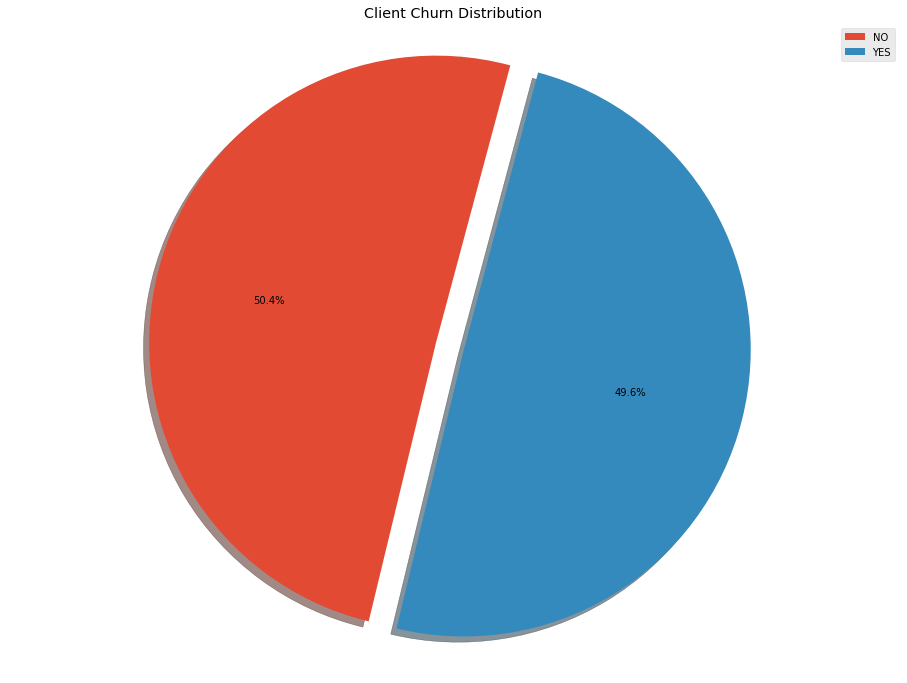

In [147]:
# ratio of those who churn and those who don't
sizes = [48401,47647]
labels='NO','YES'
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode,autopct='%1.1f%%',shadow=True, startangle=75 )
ax1.axis('equal') 
ax1.set_title("Client Churn Distribution")

ax1.legend(labels)

plt.show()

In [148]:
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass
      
    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


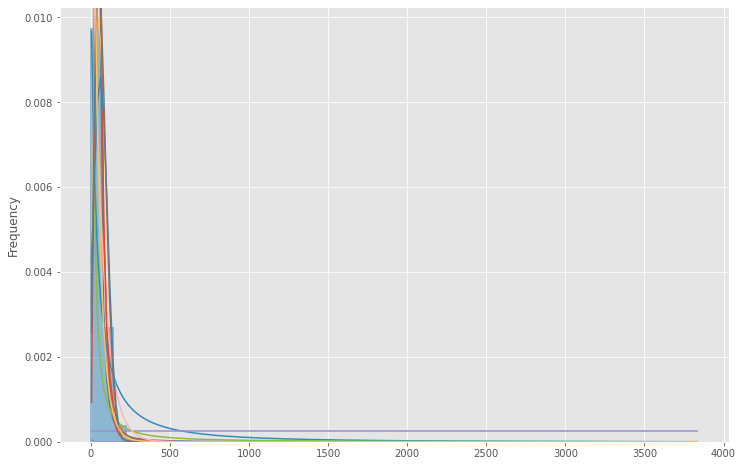

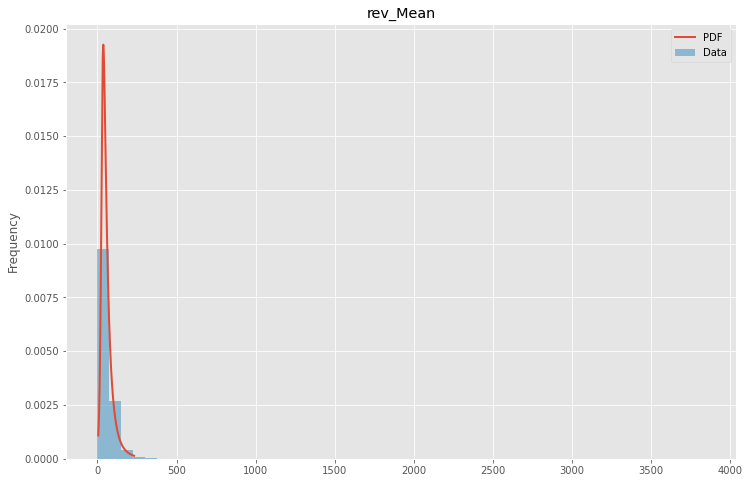

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


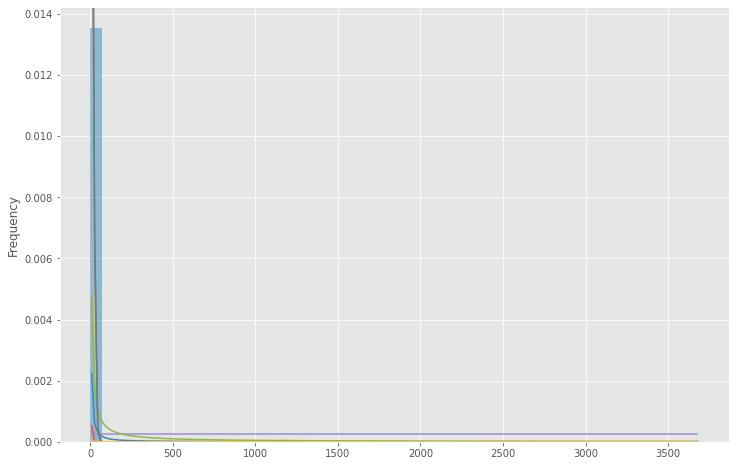

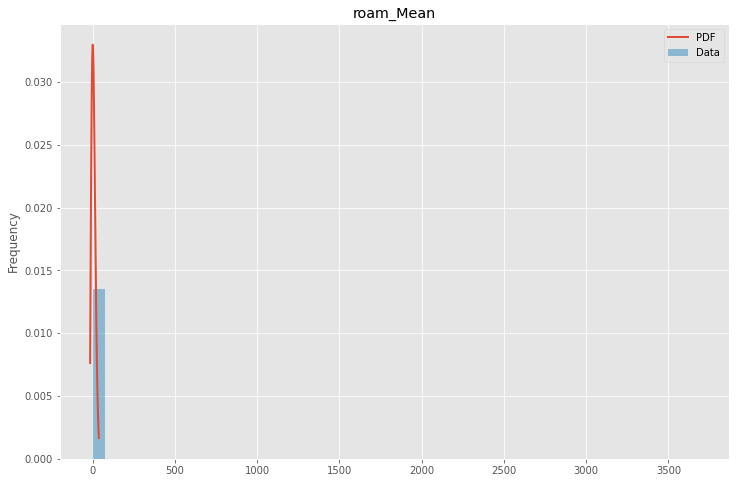

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


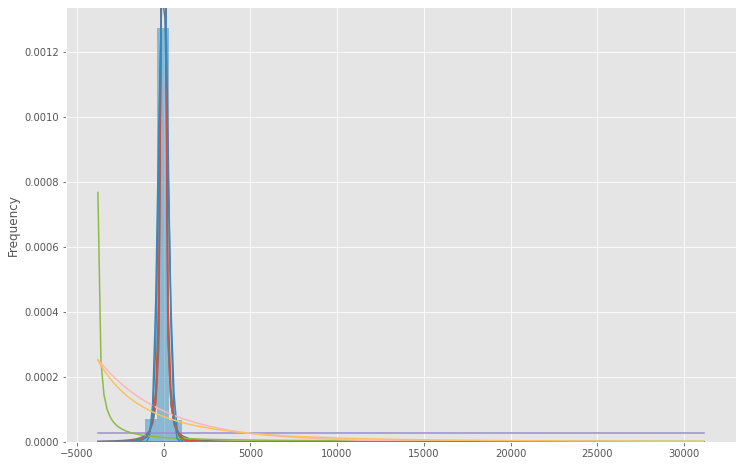

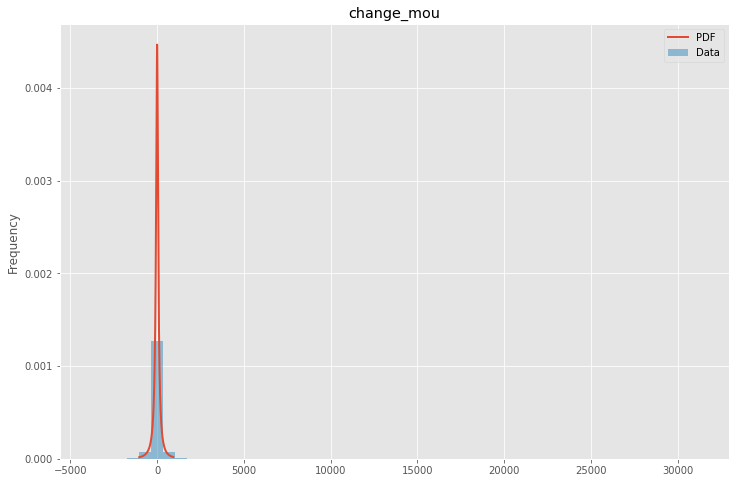

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


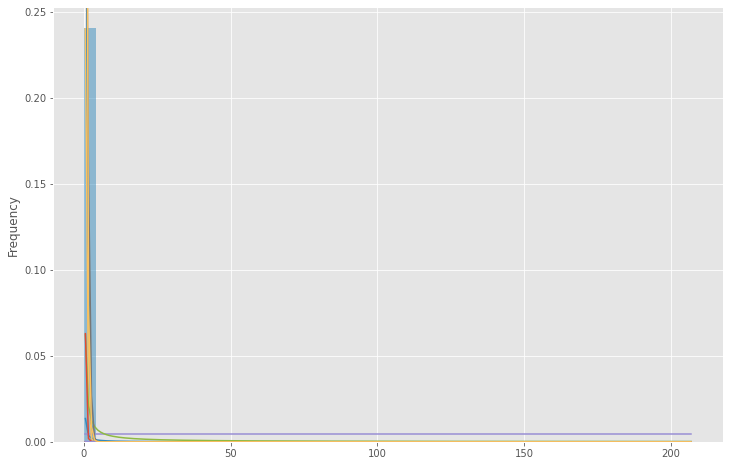

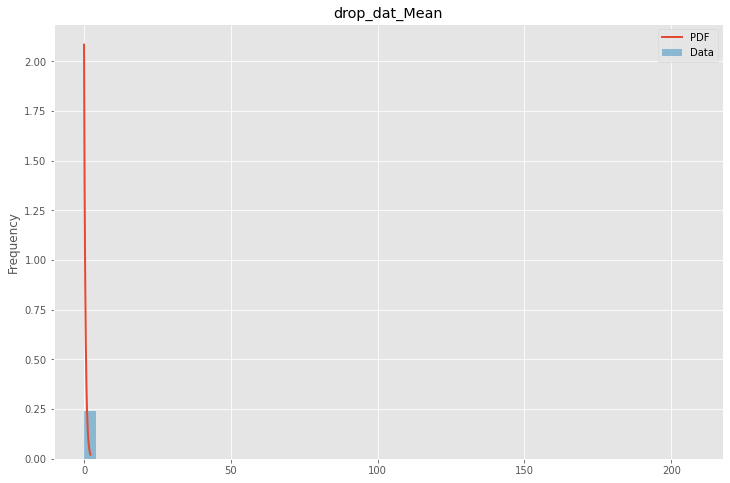

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


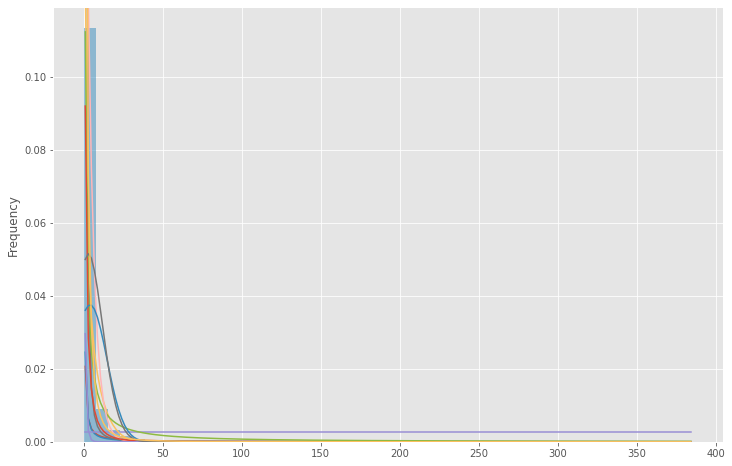

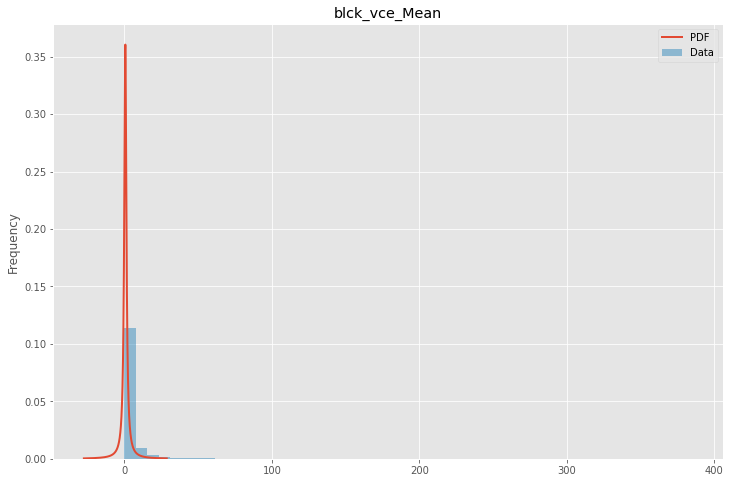

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


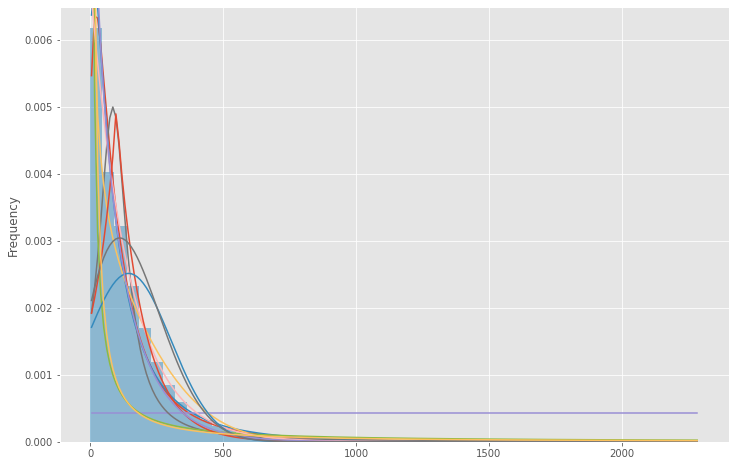

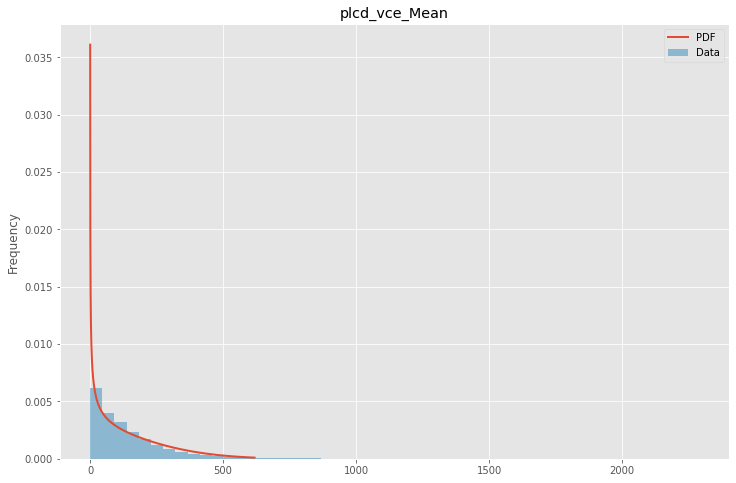

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


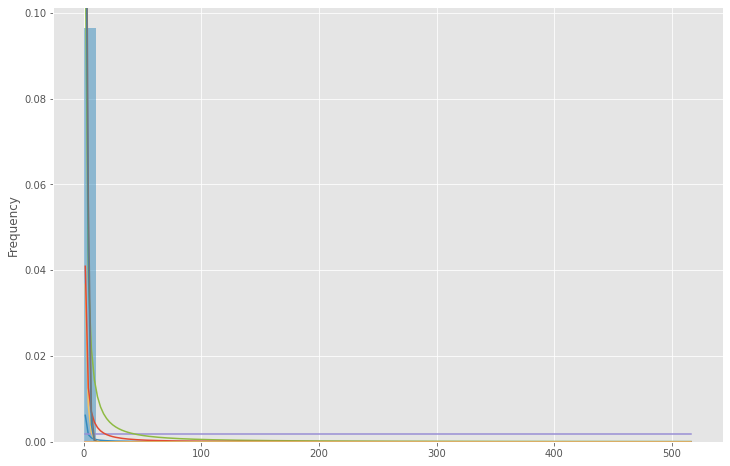

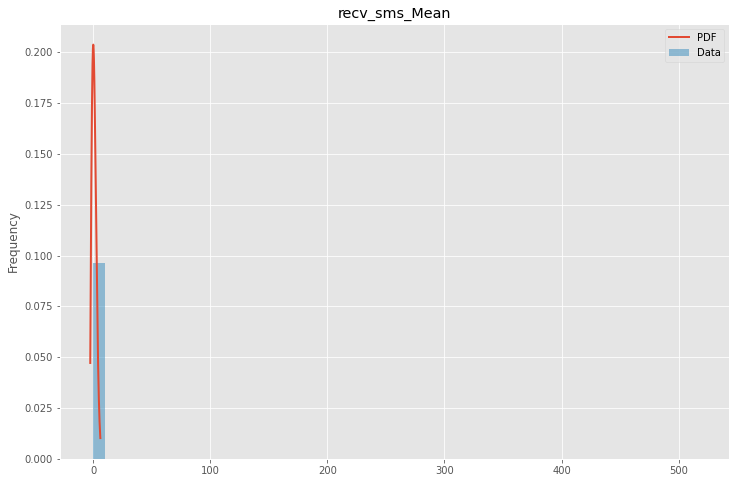

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


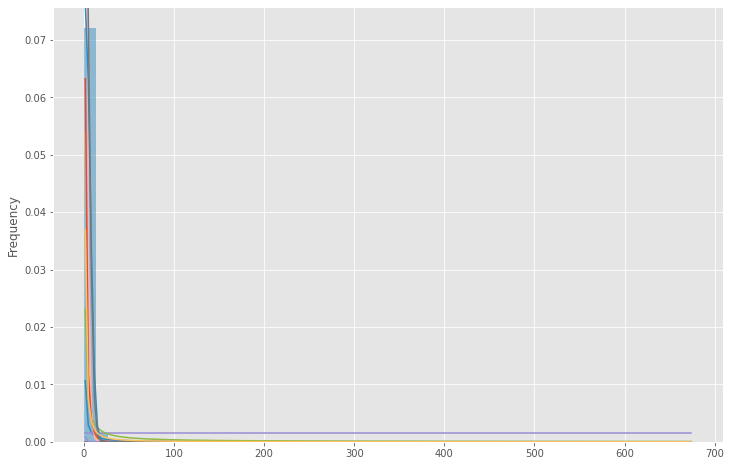

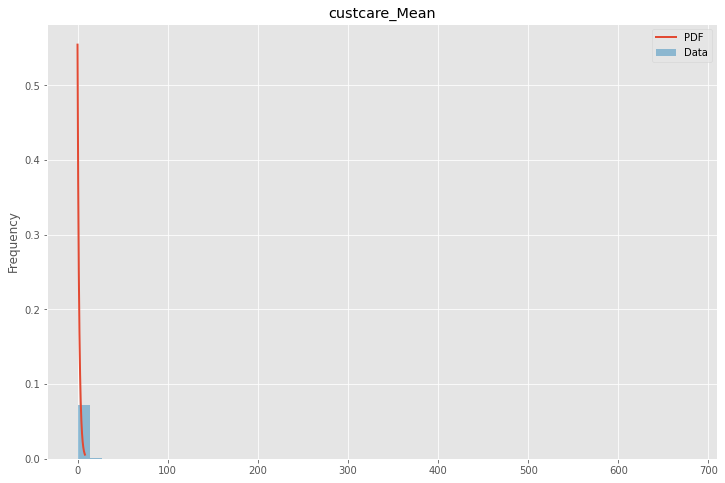

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


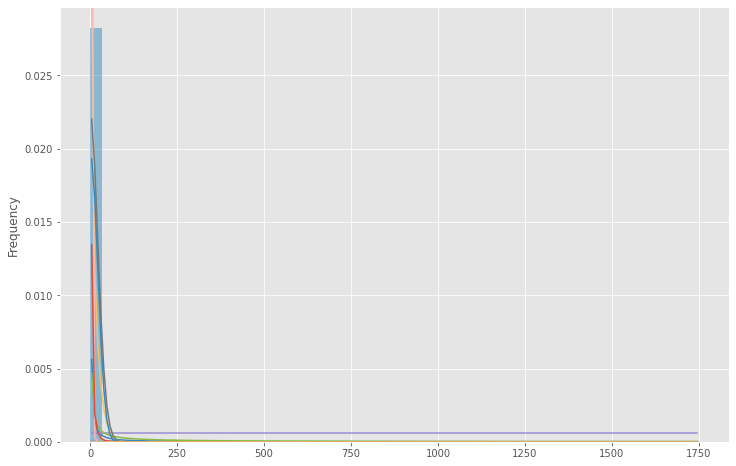

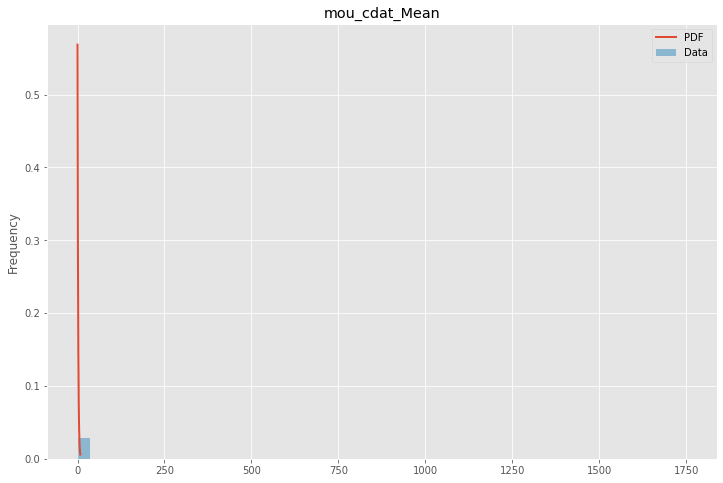

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


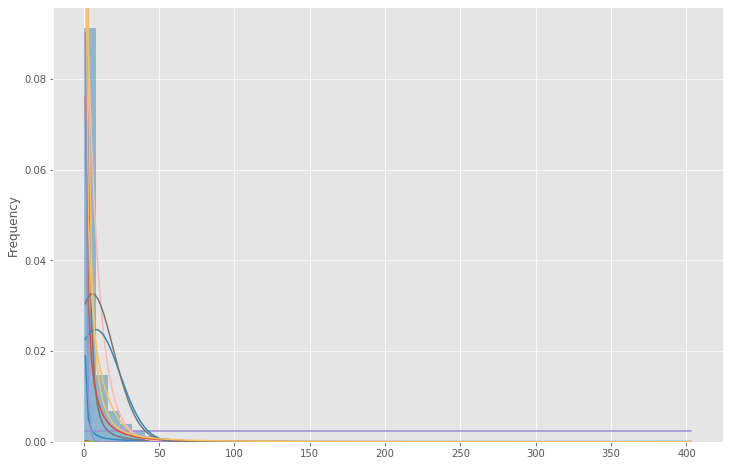

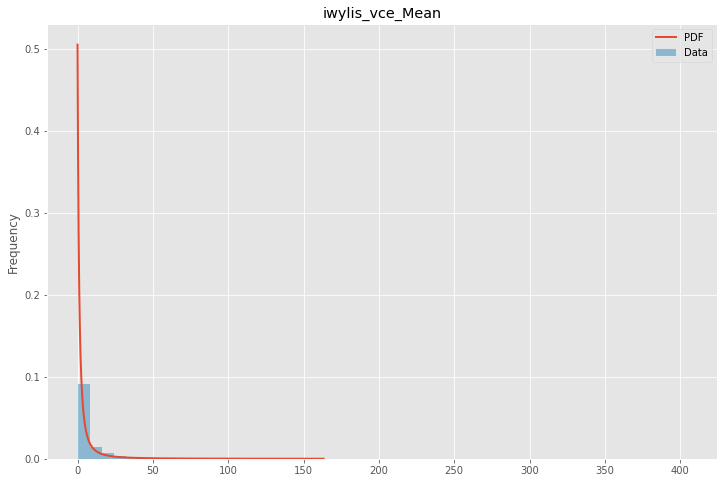

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


C:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:4322: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))


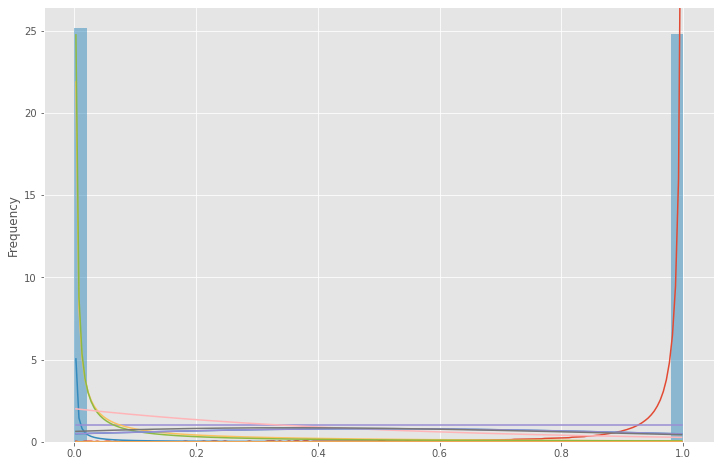

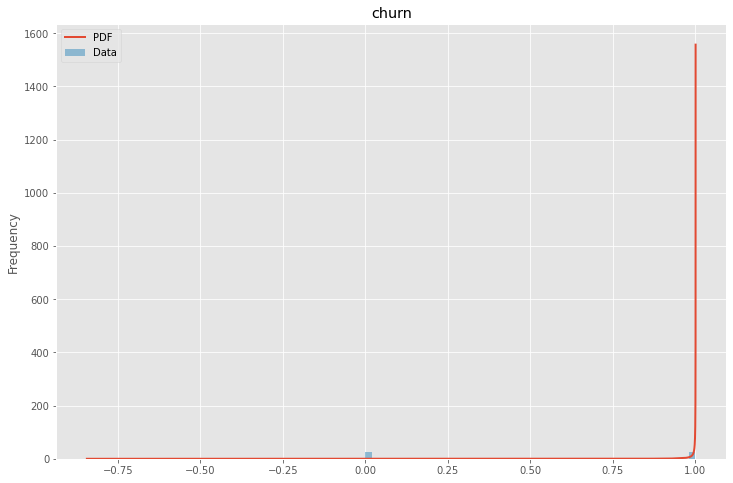

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


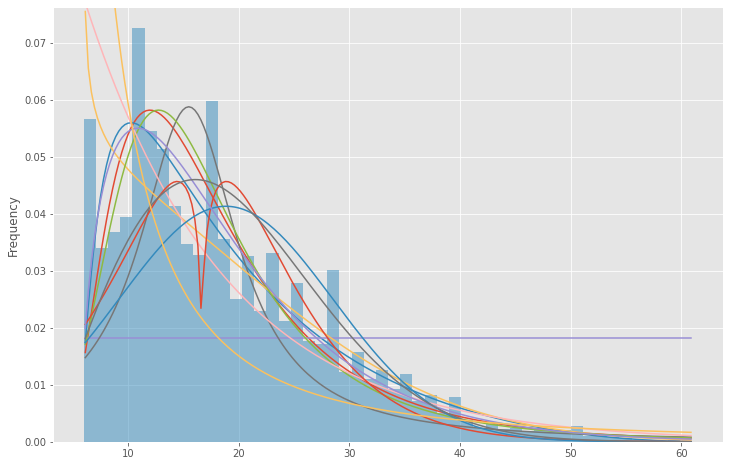

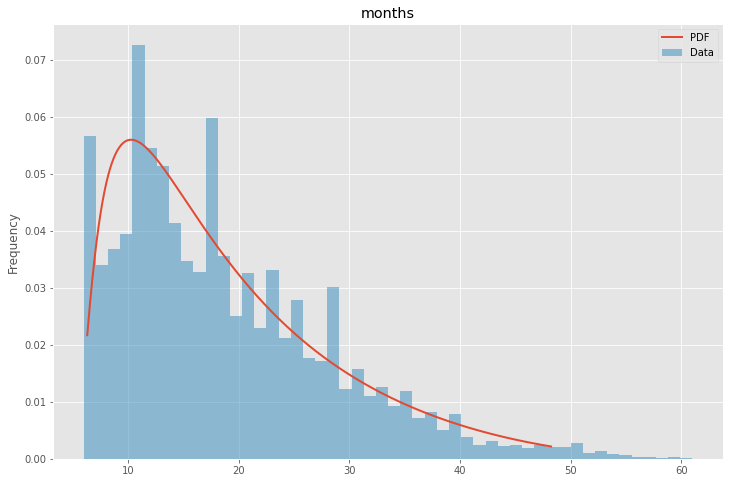

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


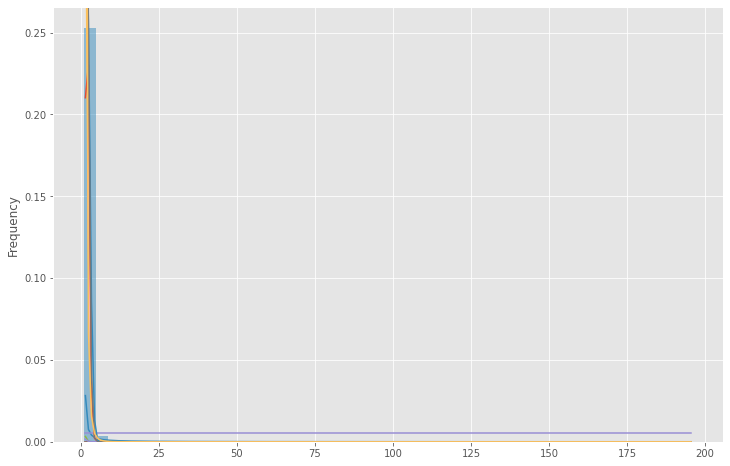

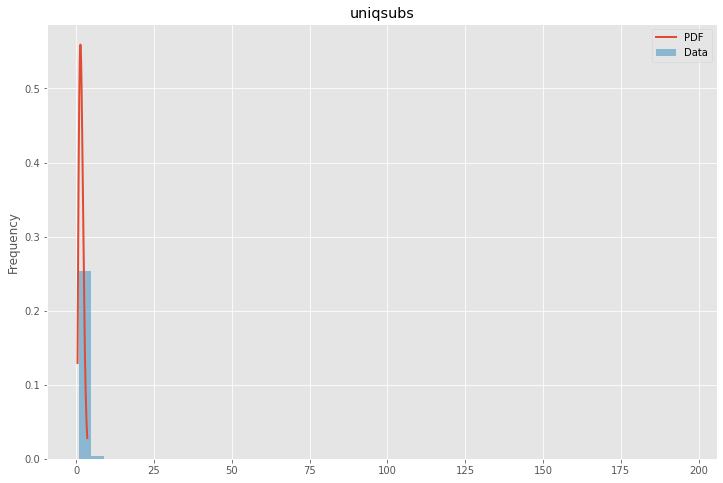

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


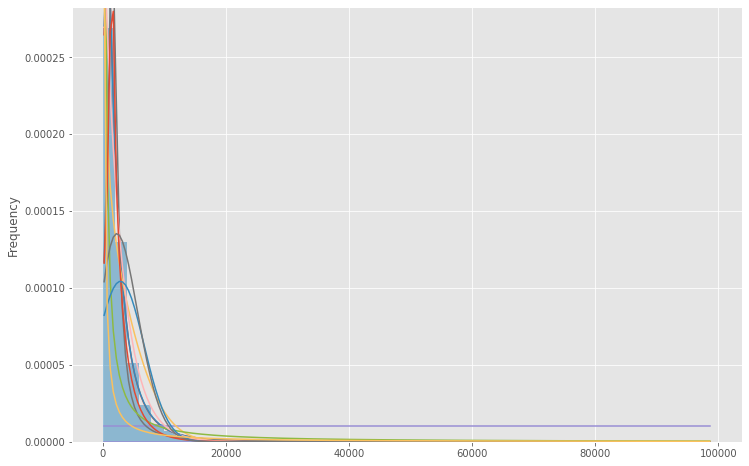

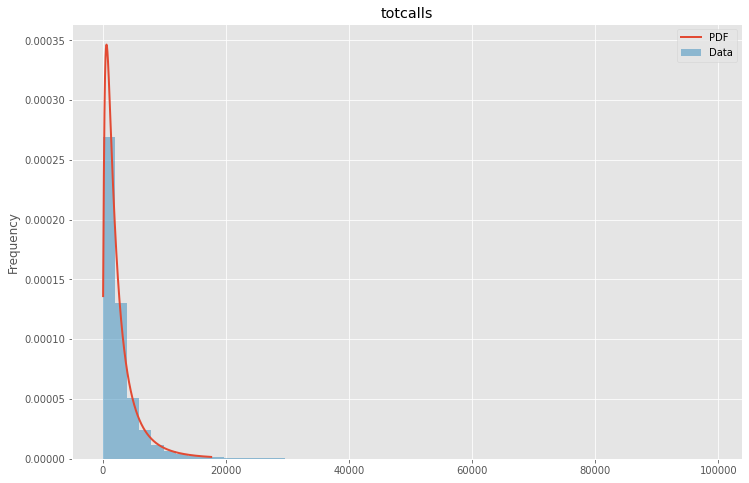

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


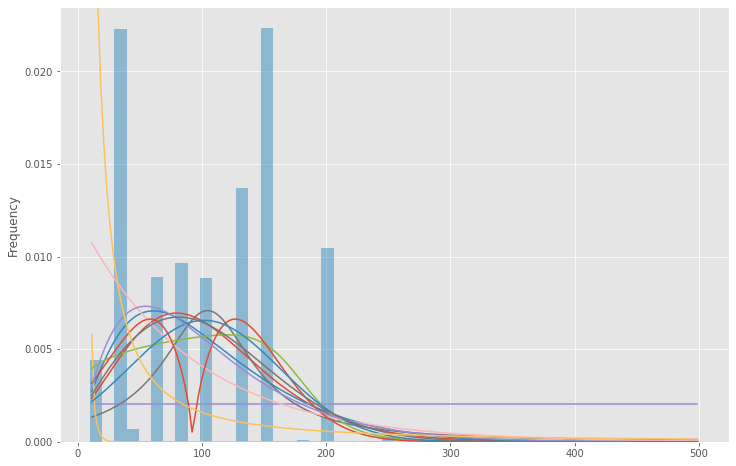

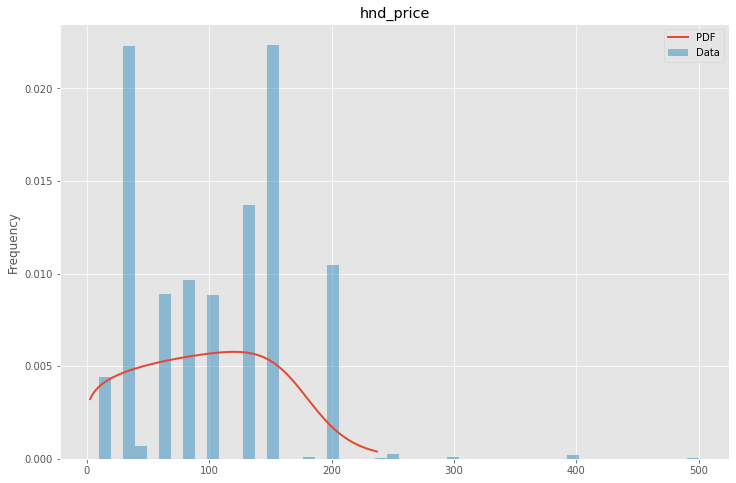

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


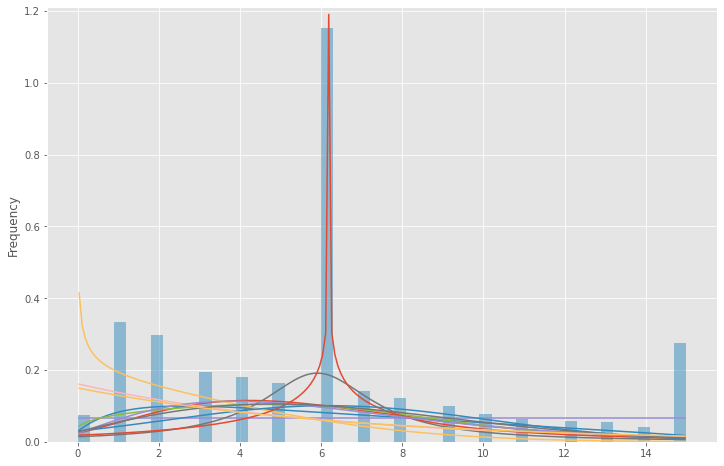

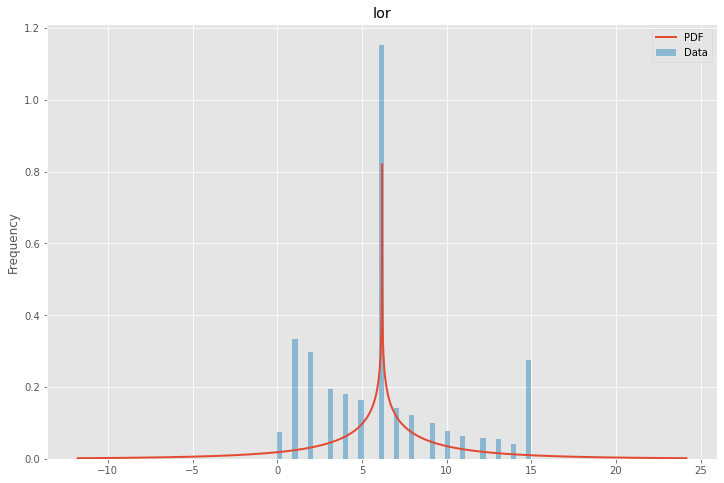

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


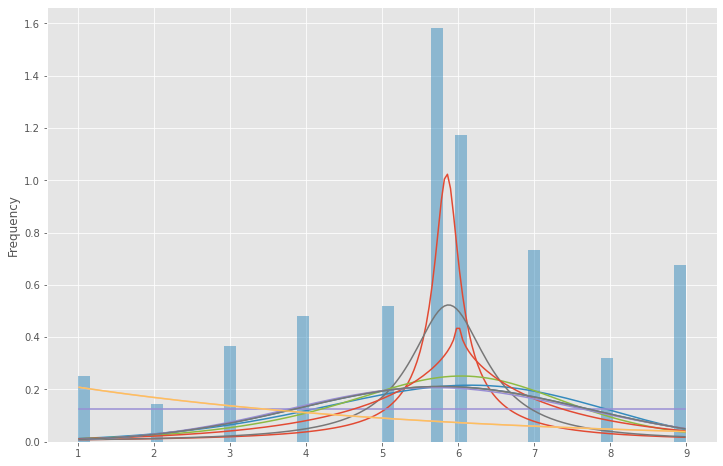

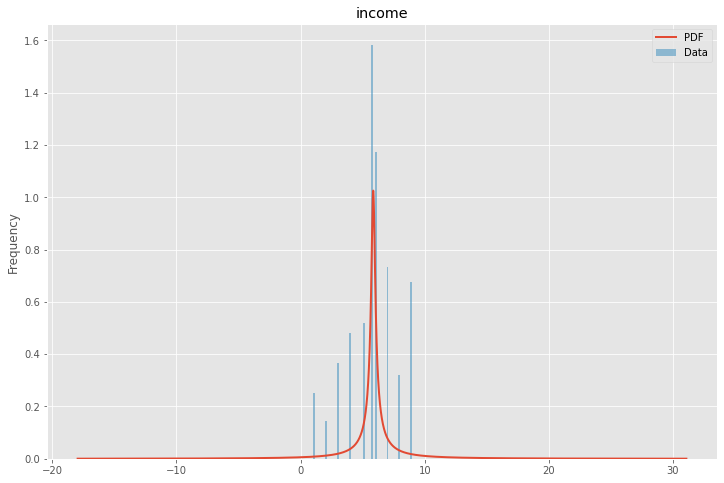

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


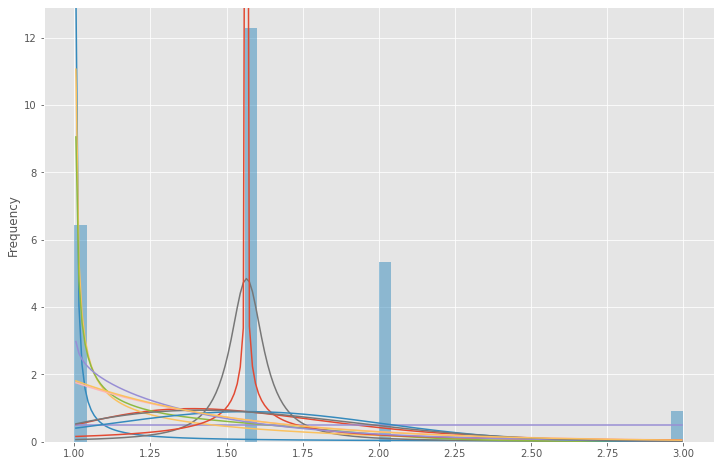

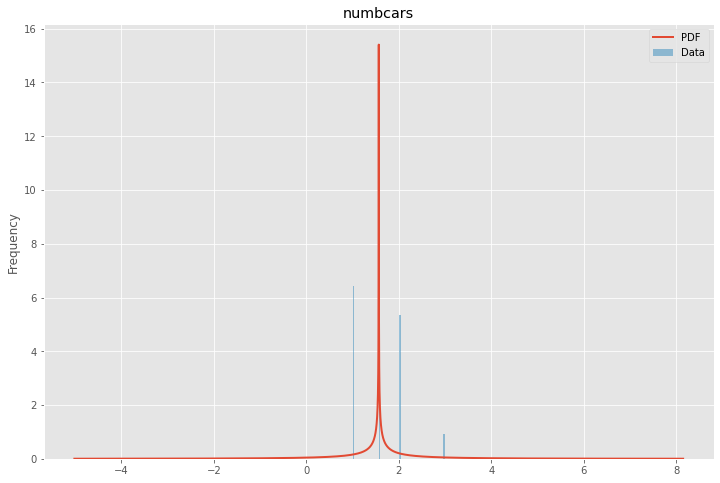

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


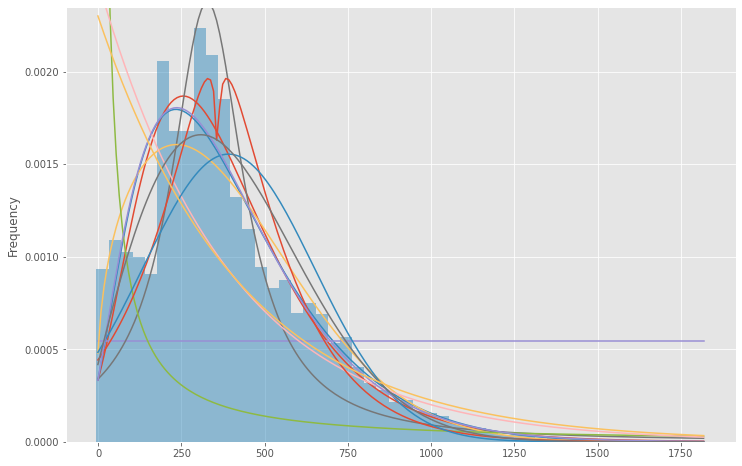

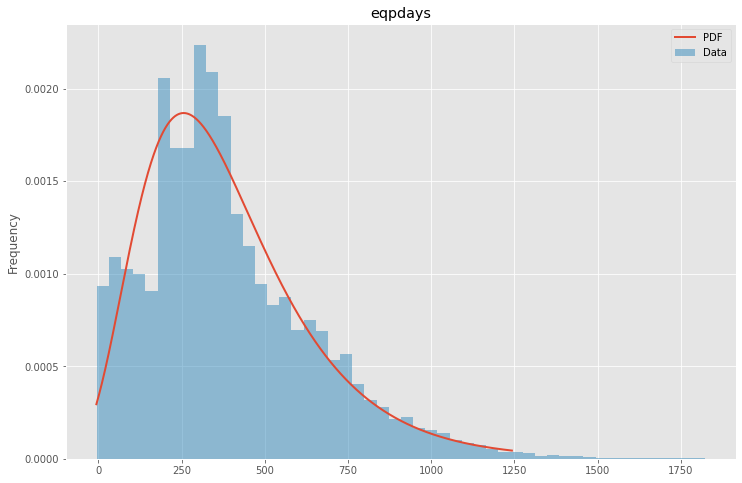

In [149]:
# Load data from statsmodels datasets
fitted = []
parameters = [] 

for column in data_numT :

    data = pd.Series(data=data_numT[column])

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])
    #plt.show()

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, 200, ax)
    best_dist = best_distibutions[0]

    # Update plots
    ax.set_ylim(dataYLim)
    #ax.set_title(" " + column)
    #ax.set_xlabel(u'Temp (°C)')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    #plt.show()
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)
    plt.title(str(column))
    plt.show()

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    #parameters.append(param_names)
    #parameters.append(param_str)
    parameters.append(dist_str) 
    fitted.append(pdf) 

In [150]:
""" plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=100, density=True, alpha=0.5, label='Data', legend=True, ax=ax) """
counter = 0
for column in data_numT :
    print(str(column) + "'s best fit:    " + str(parameters[counter]))
    counter += 1
  

rev_Mean's best fit:    johnsonsu(a=-1.18, b=1.09, loc=25.72, scale=16.66)
roam_Mean's best fit:    rice(b=0.05, loc=-17.26, scale=18.37)
change_mou's best fit:    johnsonsu(a=0.03, b=0.67, loc=-6.25, scale=59.42)
drop_dat_Mean's best fit:    pareto(b=1468757050.00, loc=-697677852.19, scale=697677852.19)
blck_vce_Mean's best fit:    cauchy(loc=0.58, scale=0.88)
plcd_vce_Mean's best fit:    chi(df=0.61, loc=-0.00, scale=268.02)
recv_sms_Mean's best fit:    rice(b=0.05, loc=-2.92, scale=2.98)
custcare_Mean's best fit:    expon(loc=0.00, scale=1.78)
mou_cdat_Mean's best fit:    expon(loc=0.00, scale=1.74)
iwylis_vce_Mean's best fit:    pareto(b=1.05, loc=-2.03, scale=2.03)
churn's best fit:    johnsonsu(a=5.00, b=0.37, loc=1.00, scale=0.00)
months's best fit:    johnsonsb(a=1.39, b=0.96, loc=5.11, scale=59.41)
uniqsubs's best fit:    rice(b=0.00, loc=0.29, scale=1.08)
totcalls's best fit:    johnsonsu(a=-5.86, b=1.04, loc=-126.92, scale=13.65)
hnd_price's best fit:    burr(c=9.74, d=0.12,

In [177]:
""" value = data_num.at[0,'eqpdays']
curr = fitted[52]
tmp = curr.loc[value:value+0.5]
tmp.iloc[0] """


pr_pdf = [] 
g = 0

while g < 80000 :
    c = 0
    p = 1
    for column in data_numT :
      value = data_numT.at[g,column]
      curr = fitted[c]
      tmp = curr.loc[value:value+1]
      if tmp.empty :
        c += 1
      else :
        k = tmp.iloc[0]
        p *= k
        c += 1
    g+=1 
    if p!= 0 :
     pr_pdf.append(p)    





  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


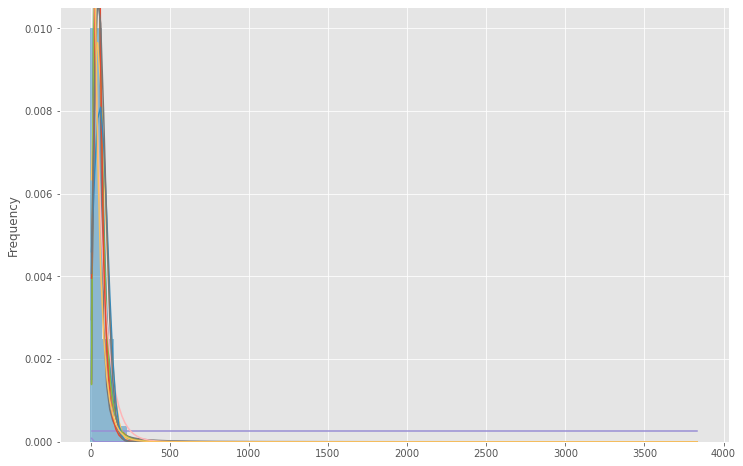

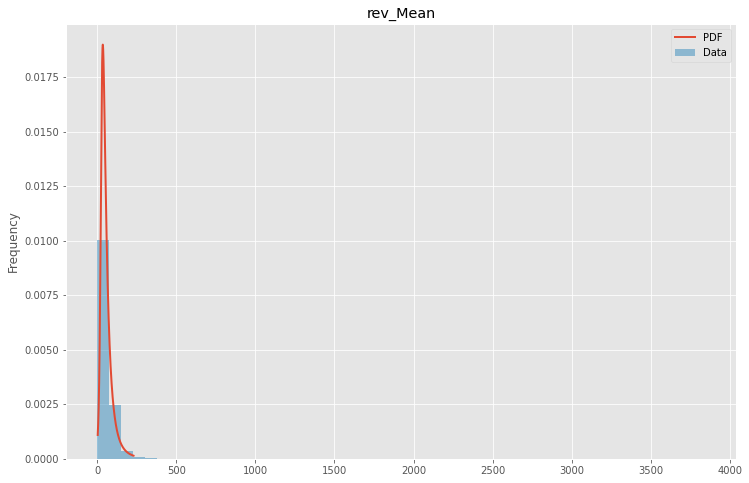

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


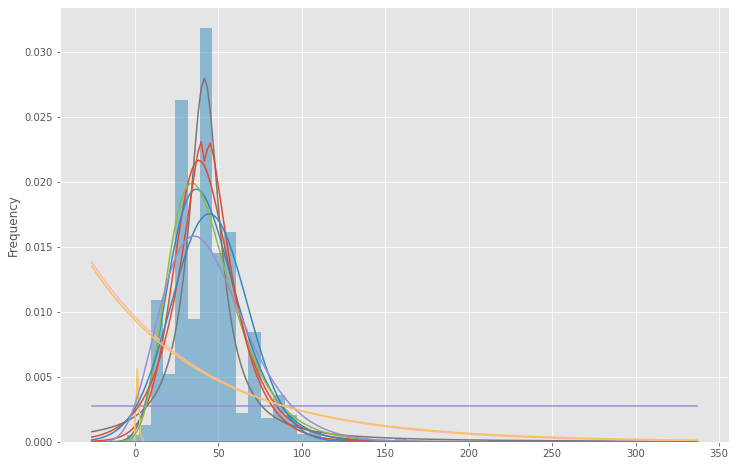

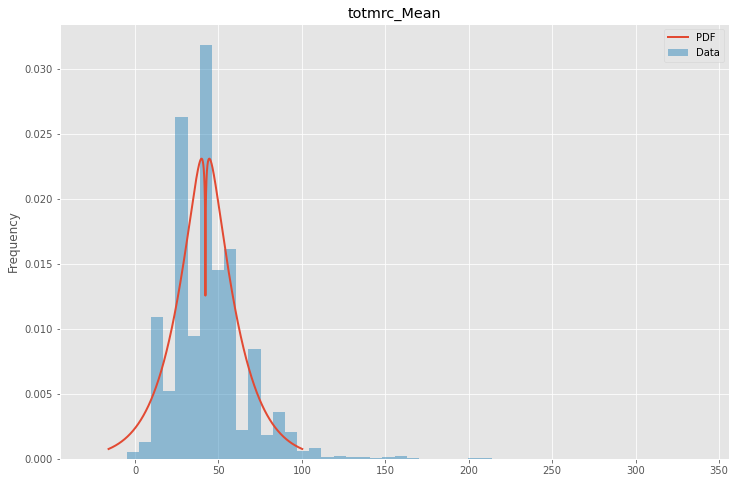

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


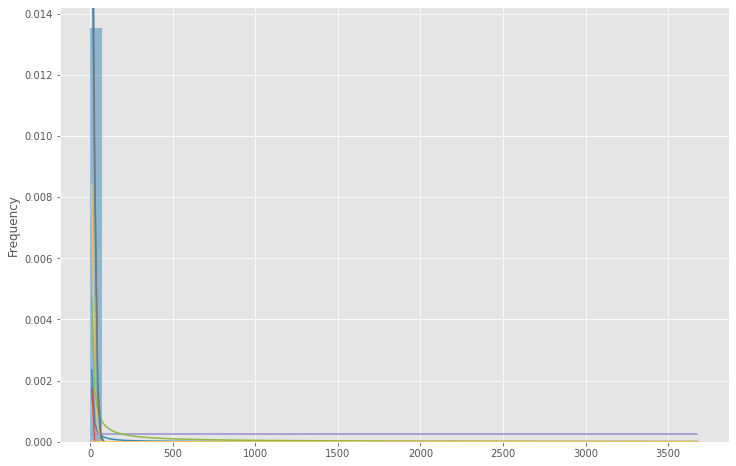

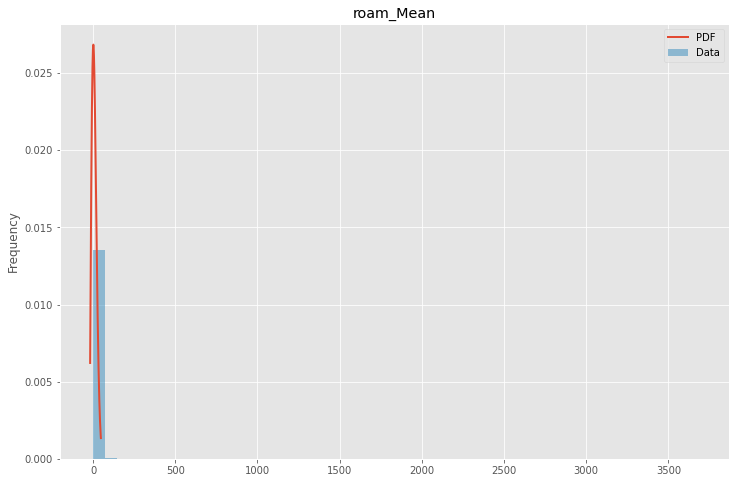

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


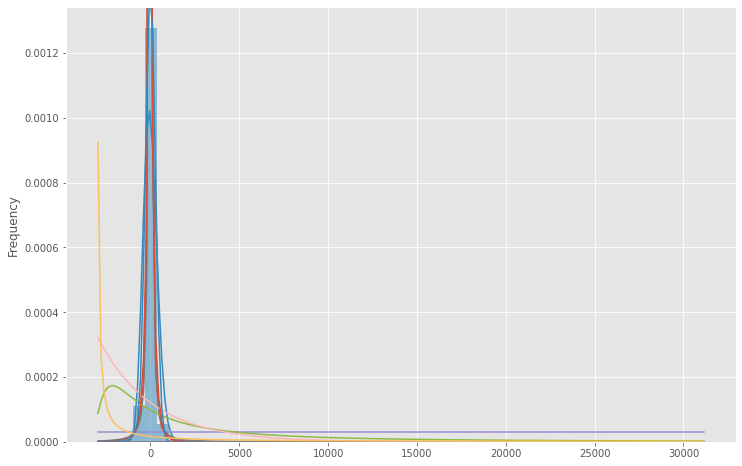

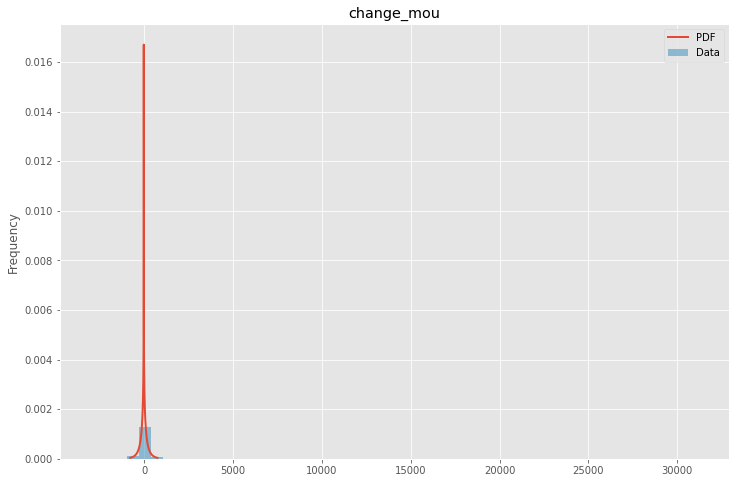

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


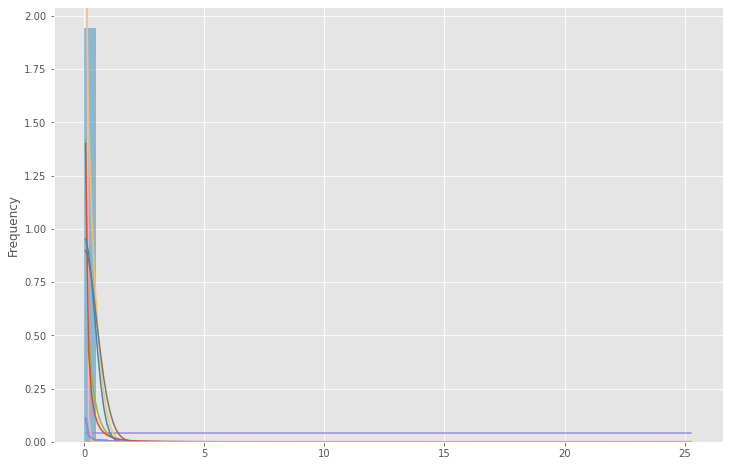

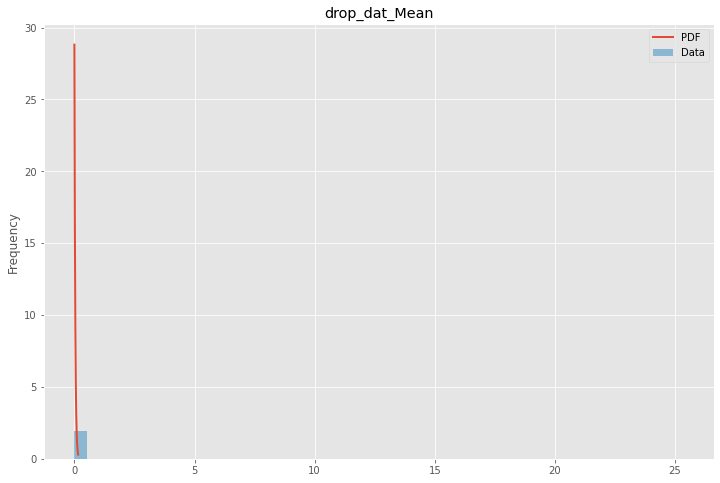

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


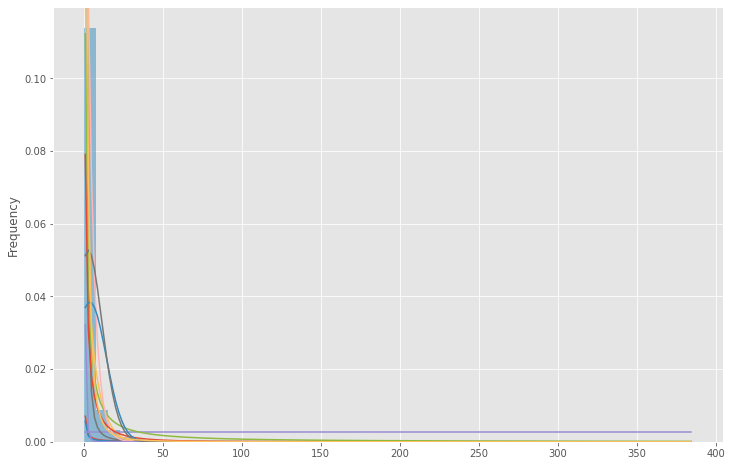

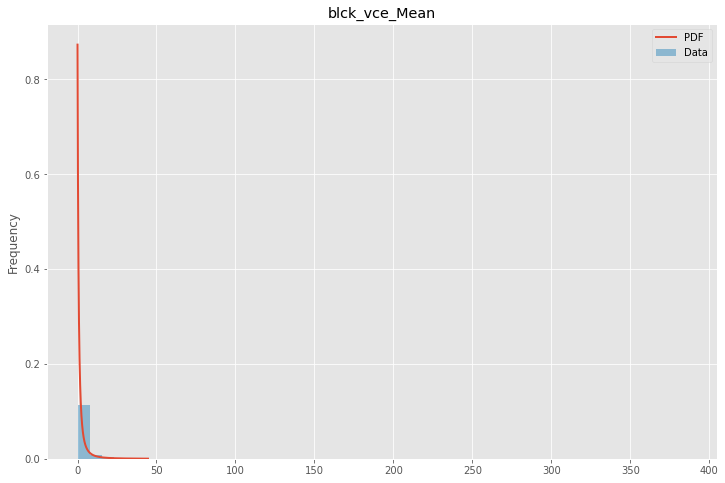

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


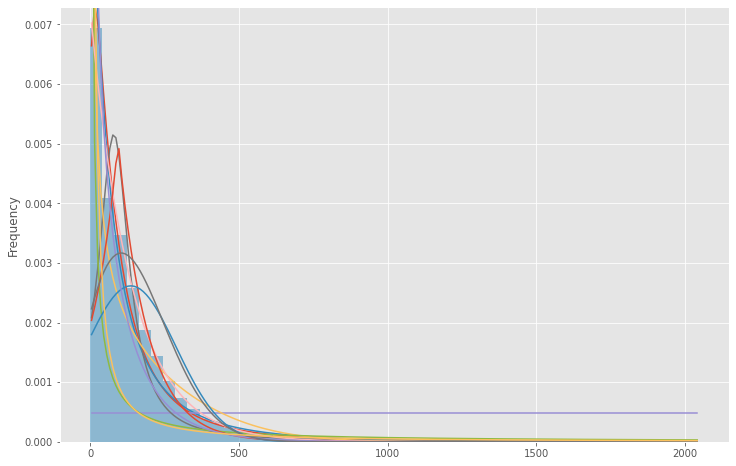

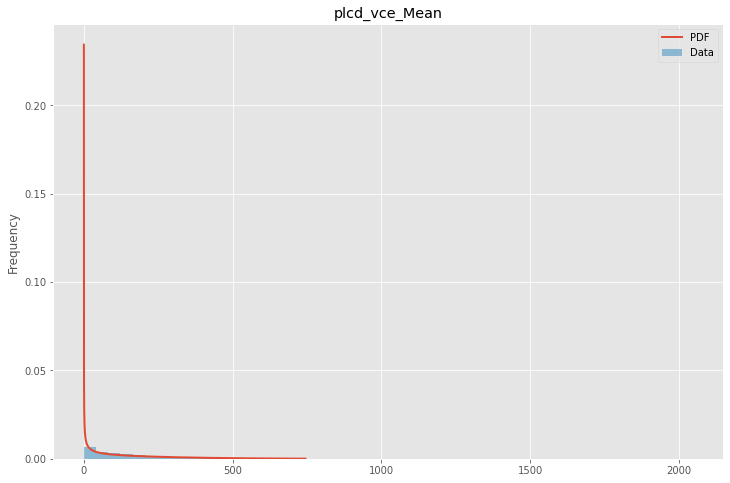

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


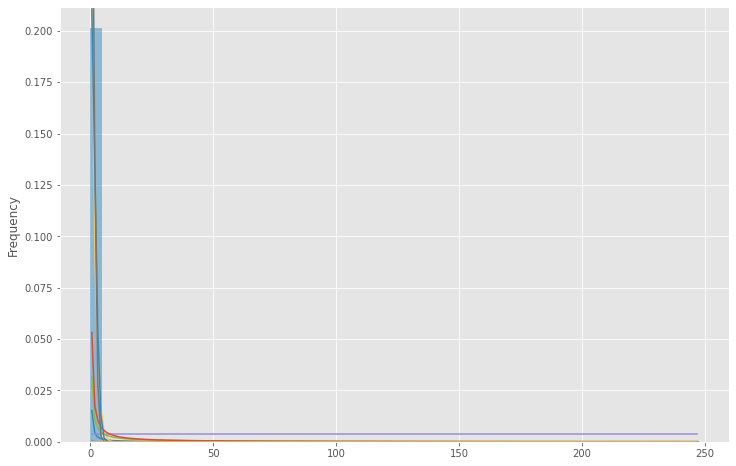

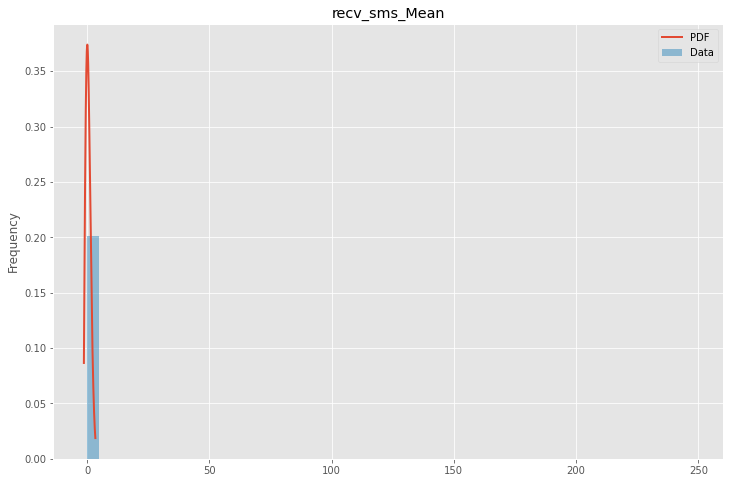

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


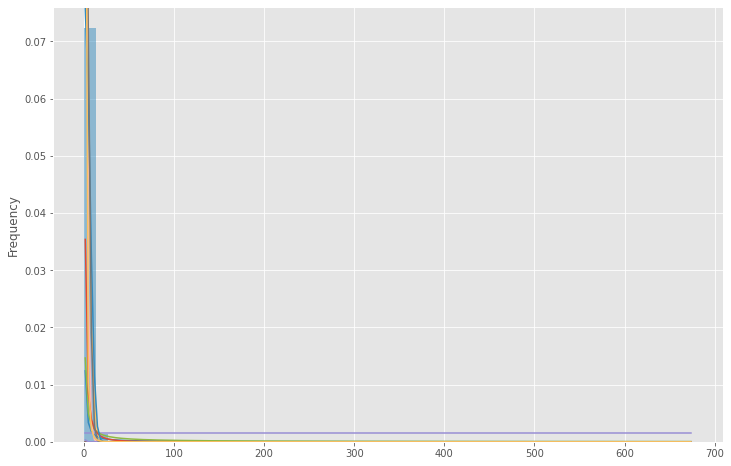

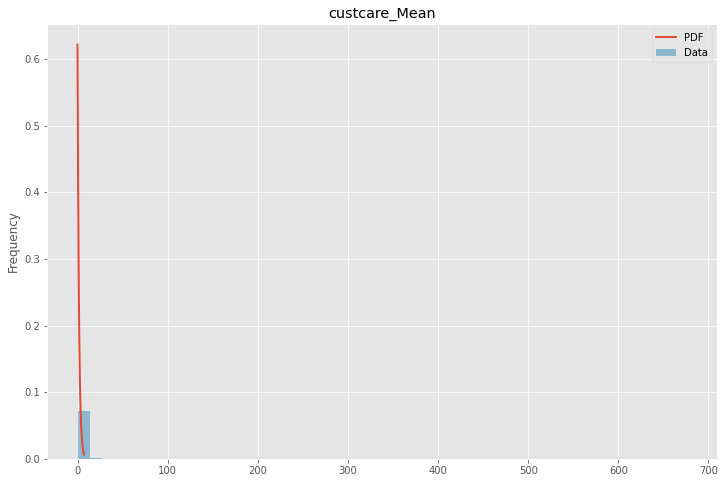

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


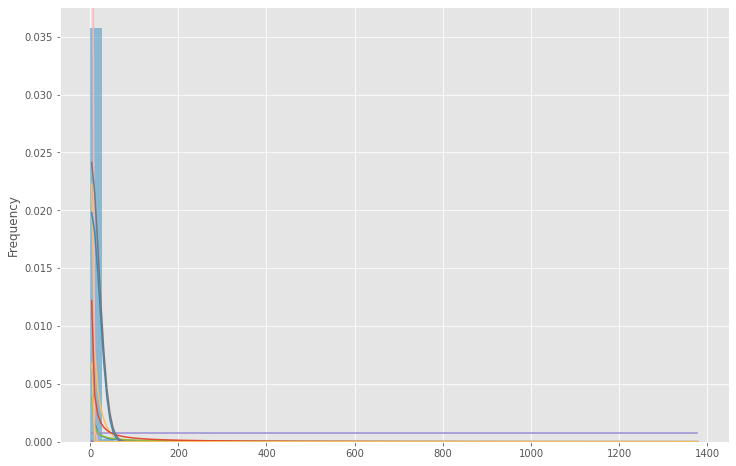

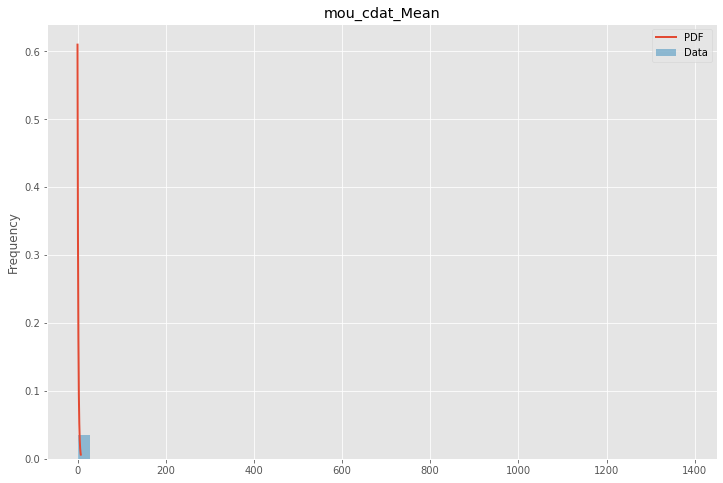

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


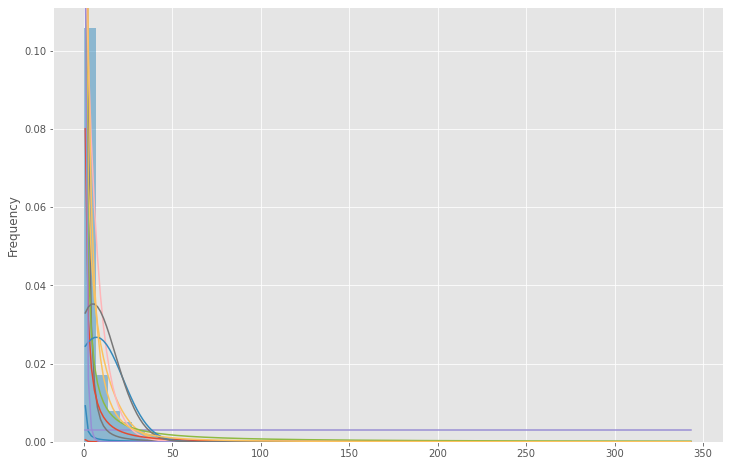

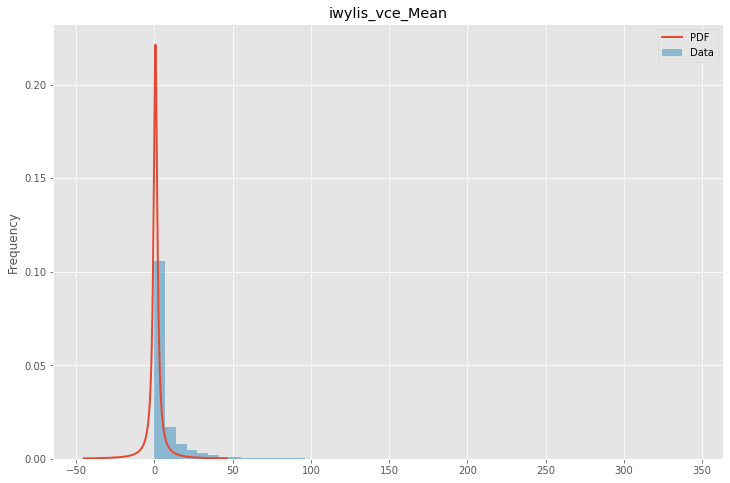

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


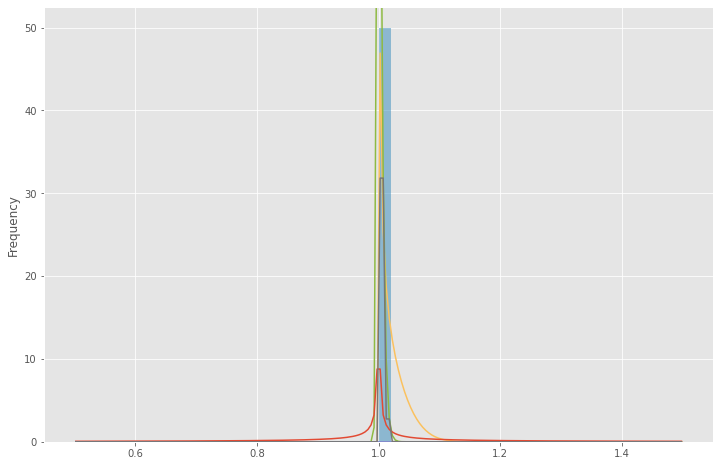

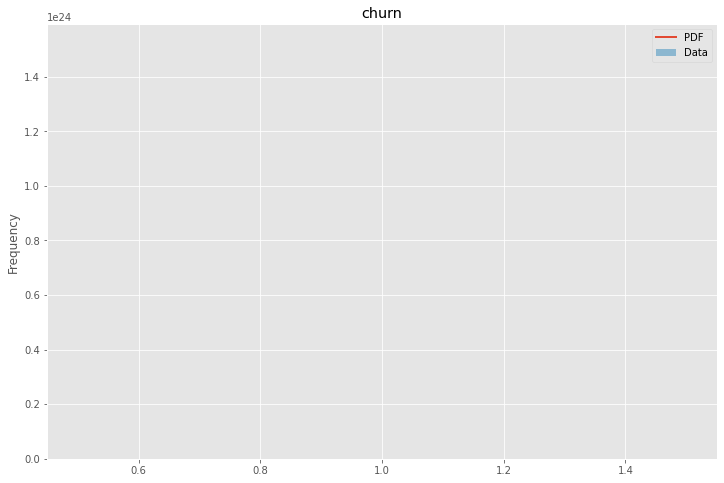

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


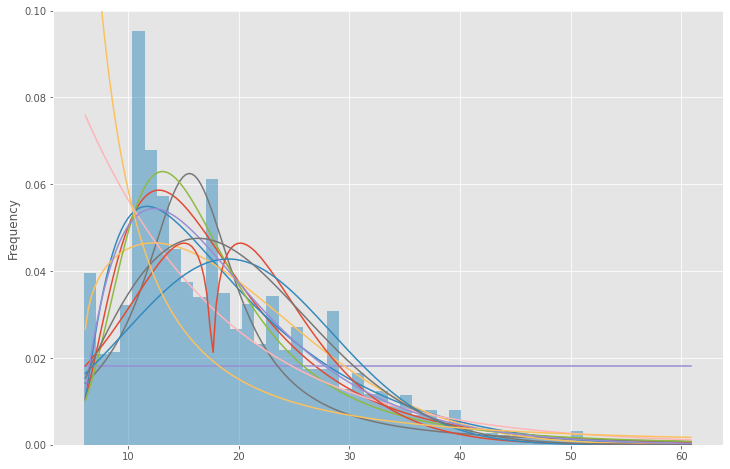

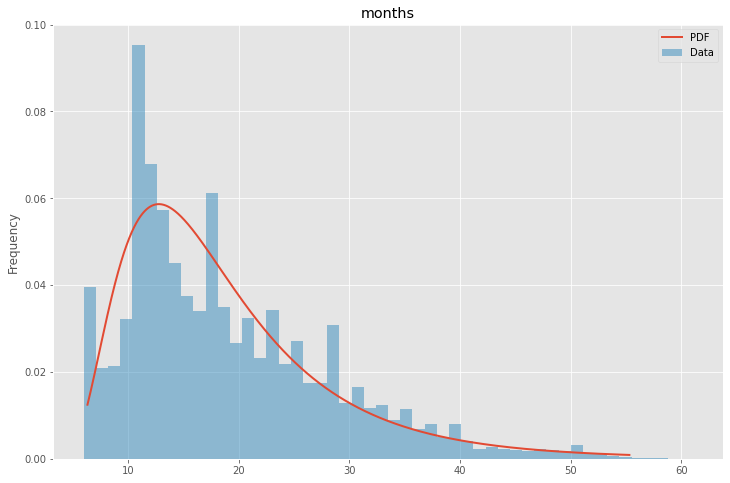

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


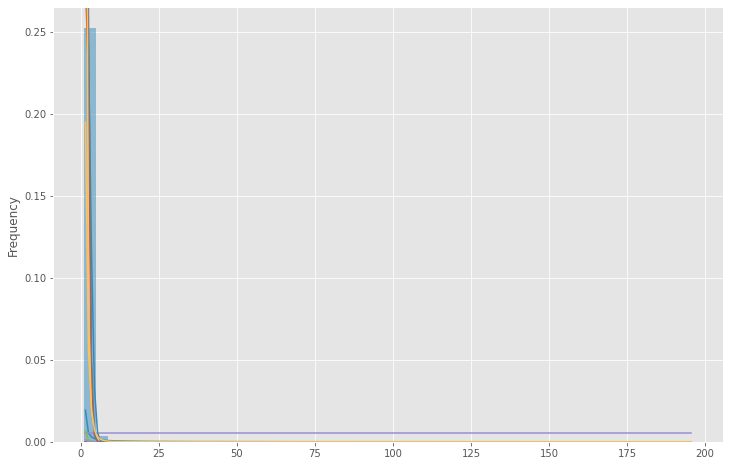

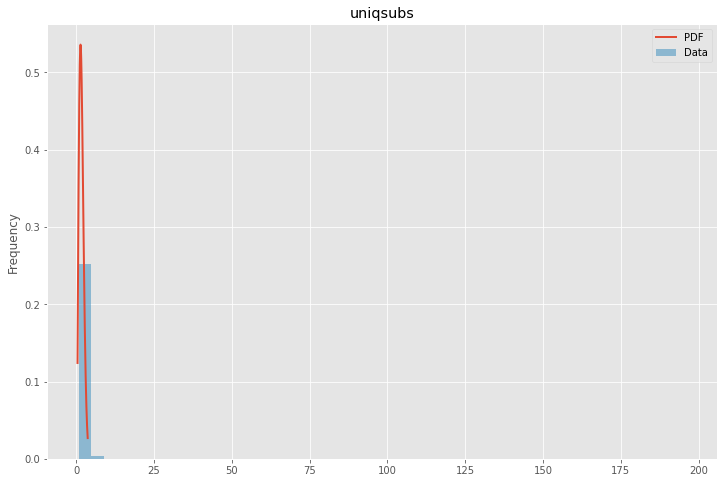

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


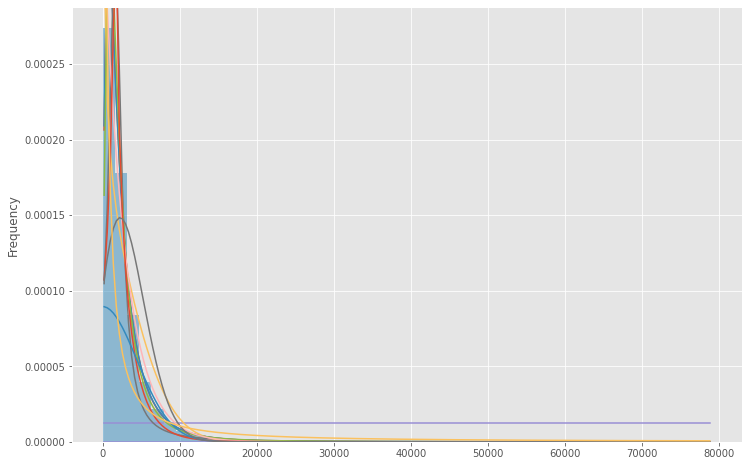

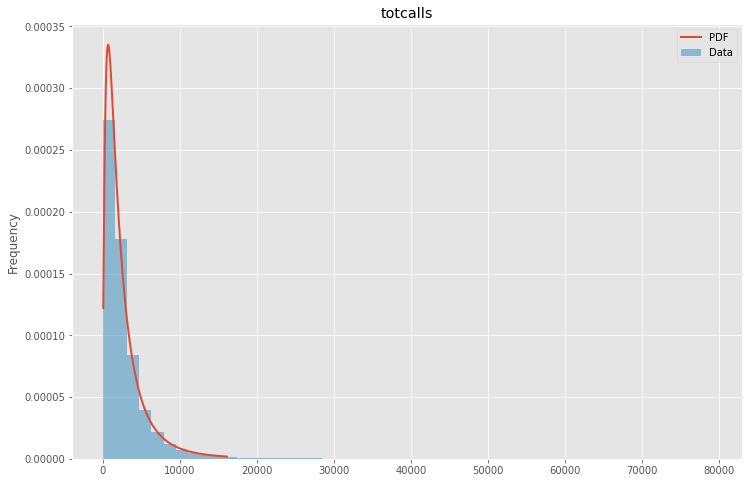

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


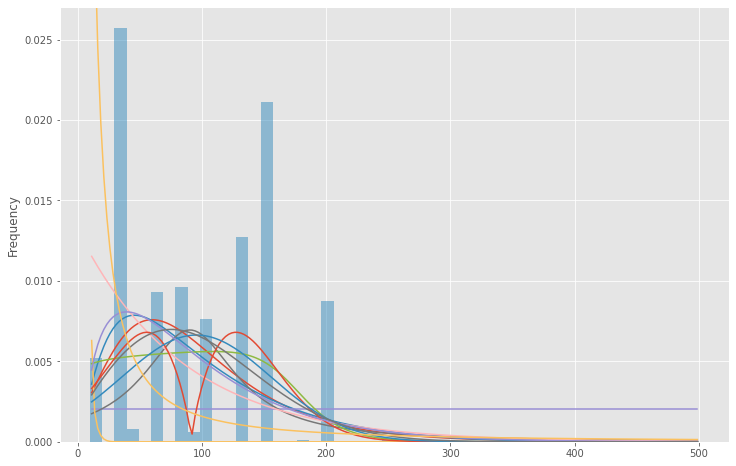

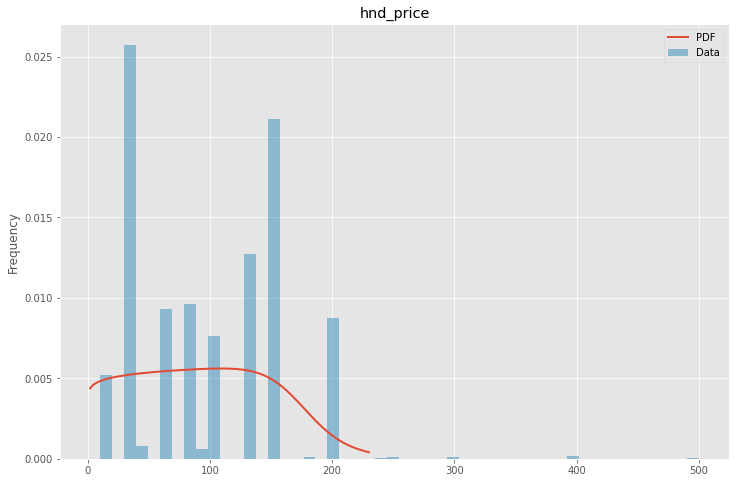

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


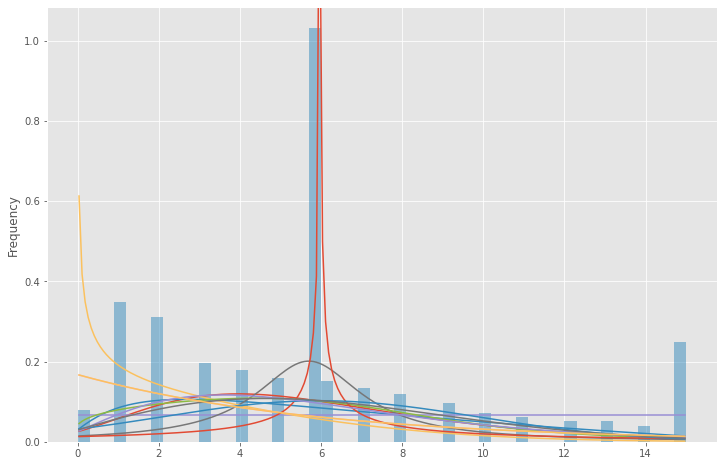

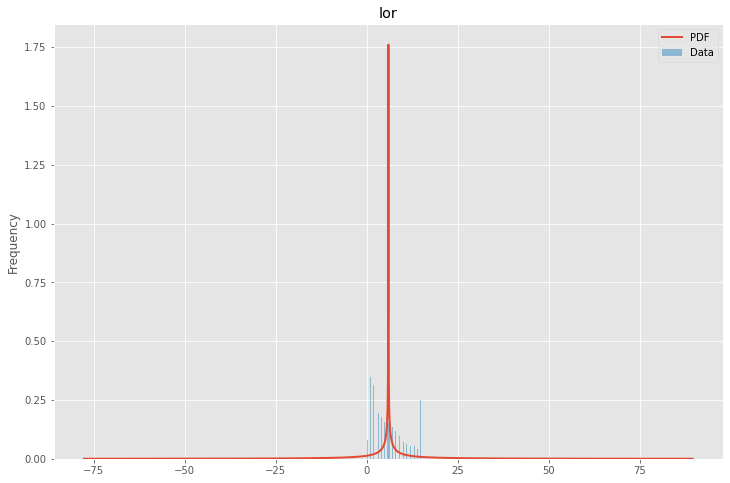

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


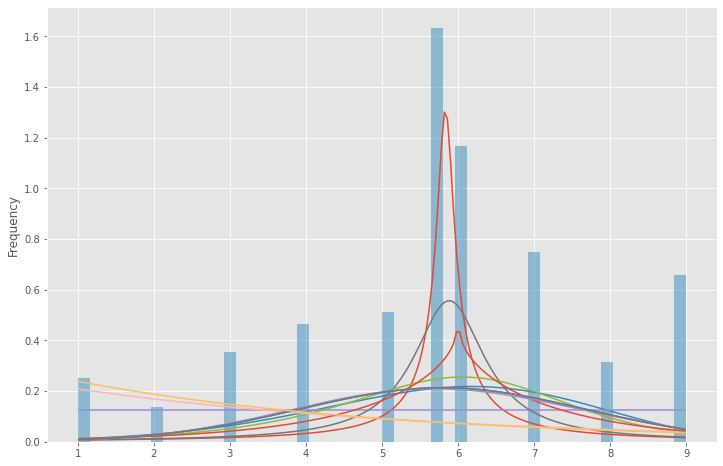

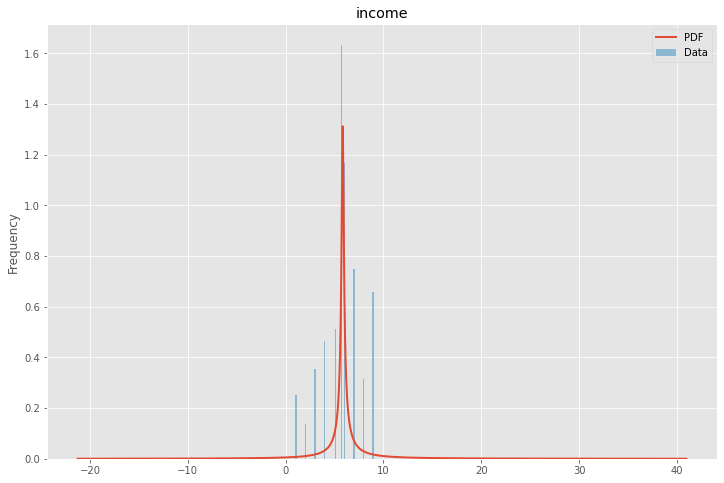

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


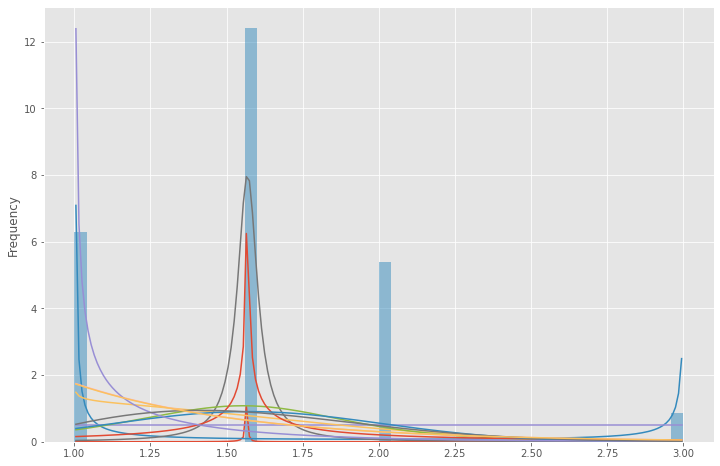

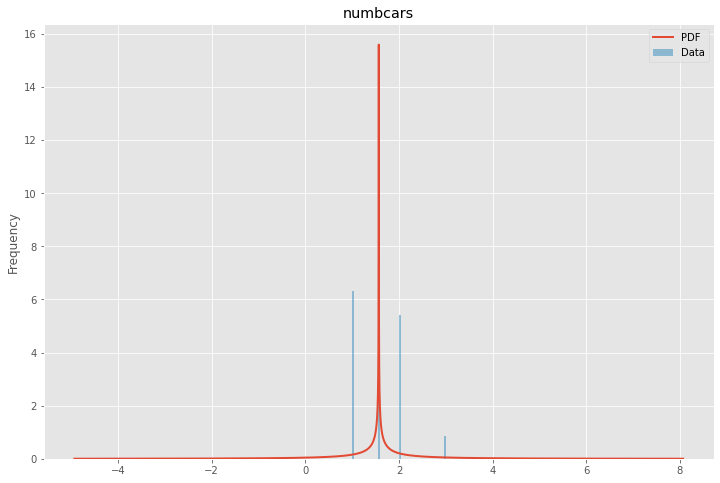

  1 / 12 : johnsonsu
  2 / 12 : johnsonsb
  3 / 12 : uniform
  4 / 12 : cauchy
  5 / 12 : chi
  6 / 12 : burr
  7 / 12 : expon
  8 / 12 : dweibull
  9 / 12 : crystalball
 10 / 12 : gamma
 11 / 12 : rice
 12 / 12 : pareto


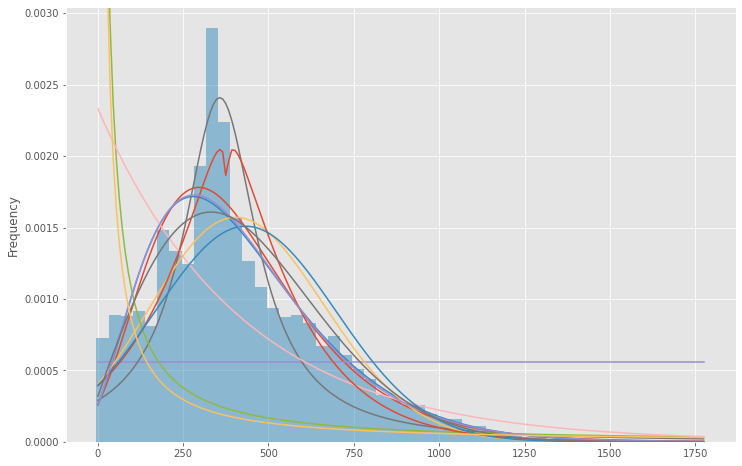

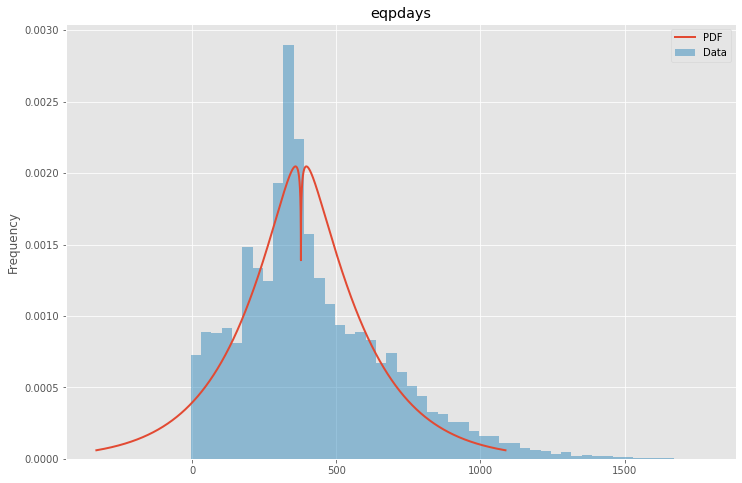

In [153]:
# Load data from statsmodels datasets
fitted_churn = []
parameters_churn = [] 

for column in data_churn_numT :

    data = pd.Series(data=data_churn_numT[column])

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])
    #plt.show()

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, 200, ax)
    best_dist = best_distibutions[0]

    # Update plots
    ax.set_ylim(dataYLim)
    #ax.set_title(" " + column)
    #ax.set_xlabel(u'Temp (°C)')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)
    plt.title(str(column))
    plt.show()

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    #parameters_churn.append(param_names)
    #parameters_churn.append(param_str)
    parameters_churn.append(dist_str) 
    fitted_churn.append(pdf) 

In [164]:
c2 = 0
p2 = 1 

for column in data_churn_numT :
    value = data_churn_numT.at[2,column]
    curr = fitted_churn[c2]
    tmp = curr.loc[value:value+1]
    if tmp.empty :
        c2 += 1
    else :
        k = tmp.iloc[0]
        p2 *= k
        c2 += 1

p2

118783.89151578877

In [185]:
p = pr_pdf[0]
print(p, p0, p1, p2)
len(pr_pdf)

8.473802600959656e-23 2.77190848236385e-11 4.40910500337704e-13 118783.89151578877


39689

In [193]:
correct_counter = 0
fail_counter = 0
cv = 0

for e in pr_pdf :

  p = pr_pdf[cv] 
  num = p2 * p1 * 0.49317 
  den = p * p0 
  p_churn = num / den

  while p_churn > 1 :
    p_churn *= 0.5

  if (data_numT.at[cv,'churn'] == 1) & (p_churn > 0.5) :
      correct_counter+=1
  else :
      fail_counter+=1  
  cv+=1          

""" training_set.at[3, "churn"]    
p_churn """
data_churn_num
p_churn
correct_counter
fail_counter




19882

In [196]:
print(correct_counter/stay, fail_counter/churn)

0.39357389818384136 0.4031469878540868
